In [1]:
import pandas as pd
import numpy as np
import os
import uuid
import base64
from vllm import LLM, SamplingParams
from math_verify import parse, verify
from tqdm import tqdm
from transformers import AutoTokenizer
from utils import evaluate_responses, verify_answer, parse_answers
from collections import Counter
from scipy.stats import spearmanr
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_auc_score, 
    roc_curve
)
from dataclasses import dataclass, field
from typing import List, Dict, Literal, Optional, Callable
from enum import Enum

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-10 19:46:47 [__init__.py:241] Automatically detected platform cuda.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Configuration

In [ ]:
# Model and dataset config
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
MODEL_ALIAS = MODEL_NAME.split("/")[-1]
DATASET_NAME = "E2H-GSM8K" #"AIME_1983_2024"  # or "E2H-GSM8K", "AIME_2025"

# Generation settings
GENERATION_SETTING_STR = "max_3000_k_1_temp_0"
GREEDY_TEMP = 0.0
SC_TEMP = 0.6
MAX_TOKENS = 3000
NUM_SC_SAMPLES = 5

PROBE_PREDICTION_SOURCE = f"{DATASET_NAME}_predicted_by_predicting_learnability"
# Paths
LABELLED_DATA_PATH = f"/VData/linna4335/llms_know_difficult/runs/{MODEL_ALIAS}/datasplits/{PROBE_PREDICTION_SOURCE}.json"
RESULTS_DIR = f"../predicting_learnability/MAJORITY_VOTE_DATA/{DATASET_NAME}"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [23]:
DATASET_NAME

'AIME_2025'

## Routing Strategy Definitions

In [4]:
class RoutingStrategy(Enum):
    """Different ways to decide which questions get SC"""
    RANDOM = "random"
    PROBE_THRESHOLD = "probe_threshold"
    PROBE_QUANTILE = "probe_quantile"
    ORACLE = "oracle"  # use ground truth (cheating, but useful for upper bound)
    ALL_GREEDY = "all_greedy"  # baseline: no SC at all
    ALL_SC = "all_sc"  # upper bound: SC on everything

@dataclass
class RouterConfig:
    """Configuration for routing strategy"""
    strategy: RoutingStrategy
    # For PROBE_THRESHOLD
    threshold: Optional[float] = None  # e.g., 0.5
    # For PROBE_QUANTILE
    quantile: Optional[float] = None  # e.g., 0.3 (bottom 30%)
    # For RANDOM
    fraction: Optional[float] = None  # e.g., 0.3 (30% of data)
    # Which column to use for probe-based routing
    score_column: str = "predicted_difficulty_sigmoid"
    # Random seed for reproducibility
    seed: int = 42
    
@dataclass
class SolverResult:
    """Result from solving a question"""
    question_idx: int
    used_sc: bool  # did we route this to SC?
    is_correct: int
    final_answer: str
    num_samples_used: int  # 1 for greedy, k for SC
    responses: List[str]  # all generated responses
    token_lengths: List[int]  # token count for each response
    predicted_score: float  # probe score
    
@dataclass  
class EvaluationMetrics:
    """Metrics for a routing strategy"""
    strategy_name: str
    overall_accuracy: float
    baseline_accuracy: float  # greedy on everything
    accuracy_gain: float  # improvement over baseline
    
    # Routing stats
    fraction_routed_to_sc: float
    avg_samples_per_question: float
    total_tokens: int
    
    # Router quality (if we have ground truth)
    router_accuracy: Optional[float] = None  # did we route the right questions?
    router_precision: Optional[float] = None  # of questions we SC'd, how many benefited?
    router_recall: Optional[float] = None  # of questions that benefit from SC, how many did we catch?
    
    # SC effectiveness
    sc_subset_accuracy: Optional[float] = None  # accuracy on questions we SC'd
    greedy_subset_accuracy: Optional[float] = None  # accuracy on questions we didn't SC
    
    def efficiency_score(self) -> float:
        """Accuracy gain per unit of compute (normalized)"""
        return self.accuracy_gain / self.avg_samples_per_question
    
    def __repr__(self):
        return f"""
Strategy: {self.strategy_name}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: {self.overall_accuracy:.2%} ({self.accuracy_gain:+.2%} vs baseline)
Baseline Accuracy: {self.baseline_accuracy:.2%}

Routing: {self.fraction_routed_to_sc:.1%} → SC, {1-self.fraction_routed_to_sc:.1%} → Greedy
Avg Samples/Question: {self.avg_samples_per_question:.2f}x
Efficiency Score: {self.efficiency_score():.4f}

Router Quality:
  Accuracy: {self.router_accuracy:.2%} (correctly identified hard/easy)
  Precision: {self.router_precision:.2%} (SC'd questions that benefited)
  Recall: {self.router_recall:.2%} (caught questions that benefit from SC)
"""

## Load Data

In [5]:
df = pd.read_json(LABELLED_DATA_PATH)

MATH_PROMPT_FORMATTING = " Please put your final answer inside \\boxed{}."
df["formatted_prompt"] = df["question"].apply(lambda x: x + MATH_PROMPT_FORMATTING)
df["id"] = [str(uuid.uuid1()) for _ in range(len(df))]
df["b64id"] = df["question"].apply(lambda x: base64.b64encode(x.encode()))

print(f"Loaded {len(df)} questions from {DATASET_NAME}")
print(f"\nPredicted difficulty stats:")
print(df["predicted_difficulty_sigmoid"].describe())

Loaded 15 questions from AIME_2025

Predicted difficulty stats:
count    15.000000
mean      0.222205
std       0.344675
min       0.000446
25%       0.003963
50%       0.050660
75%       0.265053
max       0.974512
Name: predicted_difficulty_sigmoid, dtype: float64


In [6]:
# Initialize model
llm = LLM(model=MODEL_NAME, gpu_memory_utilization=0.6)
print(f"Loaded model: {MODEL_NAME}")

INFO 12-10 19:46:50 [utils.py:326] non-default args: {'model': 'Qwen/Qwen2.5-Math-1.5B-Instruct', 'gpu_memory_utilization': 0.6, 'disable_log_stats': True}


INFO 12-10 19:46:59 [__init__.py:711] Resolved architecture: Qwen2ForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 12-10 19:46:59 [__init__.py:1750] Using max model len 4096


2025-12-10 19:47:00,681	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-10 19:47:01 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=16384.
(EngineCore_0 pid=3534827) INFO 12-10 19:47:02 [core.py:636] Waiting for init message from front-end.
(EngineCore_0 pid=3534827) INFO 12-10 19:47:02 [core.py:74] Initializing a V1 LLM engine (v0.10.1.1) with config: model='Qwen/Qwen2.5-Math-1.5B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-Math-1.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=Observabi

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.35it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.33it/s]
(EngineCore_0 pid=3534827) 


(EngineCore_0 pid=3534827) INFO 12-10 19:47:06 [default_loader.py:262] Loading weights took 0.51 seconds
(EngineCore_0 pid=3534827) INFO 12-10 19:47:06 [gpu_model_runner.py:2007] Model loading took 2.8798 GiB and 1.120731 seconds
(EngineCore_0 pid=3534827) INFO 12-10 19:47:12 [backends.py:548] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/63465de3ab/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_0 pid=3534827) INFO 12-10 19:47:12 [backends.py:559] Dynamo bytecode transform time: 5.65 s
(EngineCore_0 pid=3534827) INFO 12-10 19:47:15 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 3.002 s
(EngineCore_0 pid=3534827) INFO 12-10 19:47:16 [monitor.py:34] torch.compile takes 5.65 s in total
(EngineCore_0 pid=3534827) INFO 12-10 19:47:17 [gpu_worker.py:276] Available KV cache memory: 38.98 GiB
(EngineCore_0 pid=3534827) INFO 12-10 19:47:17 [kv_cache_utils.py:849] GPU KV cache size: 1,459,856 tokens
(EngineCore_0 pid=3

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 45.43it/s]


(EngineCore_0 pid=3534827) INFO 12-10 19:47:19 [gpu_model_runner.py:2708] Graph capturing finished in 2 secs, took 0.58 GiB
(EngineCore_0 pid=3534827) INFO 12-10 19:47:19 [core.py:214] init engine (profile, create kv cache, warmup model) took 12.30 seconds
INFO 12-10 19:47:19 [llm.py:298] Supported_tasks: ['generate']
Loaded model: Qwen/Qwen2.5-Math-1.5B-Instruct


## Baseline: Greedy Decoding on Everything

In [7]:
def run_greedy_baseline(llm, df):
    """Get baseline greedy performance on all questions"""
    prompts = df["formatted_prompt"].to_list()
    gts = df["answer"].to_list()
    
    params = SamplingParams(temperature=GREEDY_TEMP, max_tokens=MAX_TOKENS)
    outputs = llm.generate(prompts, params)
    
    responses = []
    token_lengths = []
    is_correct = []
    
    for output, gt in zip(outputs, gts):
        response = output.outputs[0].text
        token_length = len(output.outputs[0].token_ids)
        
        responses.append(response)
        token_lengths.append(token_length)
        
        # Verify answer
        parsed_answers = parse_answers([response])
        if parsed_answers and len(parsed_answers[0]) > 0:
            final_answer = parsed_answers[0][0]
        else:
            final_answer = ""
        
        correct = verify(parse(f"${gt}$"), final_answer)
        is_correct.append(int(correct))
    
    accuracy = np.mean(is_correct)
    print(f"Greedy Baseline Accuracy: {accuracy:.2%} ({sum(is_correct)}/{len(is_correct)})")
    
    return responses, token_lengths, is_correct

In [8]:
# Run baseline (cache this so we don't regenerate)
baseline_responses, baseline_tokens, baseline_correct = run_greedy_baseline(llm, df)

df["baseline_response"] = baseline_responses
df["baseline_token_length"] = baseline_tokens
df["baseline_is_correct"] = baseline_correct

BASELINE_ACCURACY = np.mean(baseline_correct)

Processed prompts: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s, est. speed input: 430.67 toks/s, output: 3006.35 toks/s]

Greedy Baseline Accuracy: 13.33% (2/15)


## Router Implementation

In [9]:
def create_routing_mask(df: pd.DataFrame, config: RouterConfig) -> np.ndarray:
    """
    Create boolean mask: True = route to SC, False = use greedy
    
    Returns:
        np.ndarray of bools, same length as df
    """
    n = len(df)
    
    if config.strategy == RoutingStrategy.ALL_GREEDY:
        return np.zeros(n, dtype=bool)
    
    elif config.strategy == RoutingStrategy.ALL_SC:
        return np.ones(n, dtype=bool)
    
    elif config.strategy == RoutingStrategy.RANDOM:
        assert config.fraction is not None, "fraction required for RANDOM strategy"
        np.random.seed(config.seed)
        mask = np.random.rand(n) < config.fraction
        return mask
    
    elif config.strategy == RoutingStrategy.PROBE_THRESHOLD:
        assert config.threshold is not None, "threshold required for PROBE_THRESHOLD"
        # Lower score = harder = should use SC
        scores = df[config.score_column].values
        mask = scores < config.threshold
        return mask
    
    elif config.strategy == RoutingStrategy.PROBE_QUANTILE:
        assert config.quantile is not None, "quantile required for PROBE_QUANTILE"
        # Route bottom-k% (hardest questions)
        scores = df[config.score_column].values
        threshold = np.quantile(scores, config.quantile)
        mask = scores <= threshold
        return mask
    
    elif config.strategy == RoutingStrategy.ORACLE:
        # Cheat: use ground truth to identify questions that benefit from SC
        # This requires us to have SC results already... we'll implement this last
        raise NotImplementedError("Oracle routing requires SC results first")
    
    else:
        raise ValueError(f"Unknown strategy: {config.strategy}")

def print_routing_stats(mask: np.ndarray, config: RouterConfig):
    """Print stats about routing decisions"""
    n_sc = mask.sum()
    n_total = len(mask)
    frac_sc = n_sc / n_total
    
    print(f"\n{'='*50}")
    print(f"Routing Strategy: {config.strategy.value}")
    print(f"{'='*50}")
    print(f"SC: {n_sc}/{n_total} ({frac_sc:.1%})")
    print(f"Greedy: {n_total - n_sc}/{n_total} ({1-frac_sc:.1%})")
    print(f"Avg samples per question: {1 + frac_sc * (NUM_SC_SAMPLES - 1):.2f}x")
    print(f"{'='*50}\n")

## Self-Consistency Evaluation

In [10]:
def run_self_consistency(llm, prompt: str, gt: str, num_samples: int = NUM_SC_SAMPLES) -> Dict:
    """
    Run self-consistency on a single question
    
    Returns:
        dict with keys: is_correct, final_answer, responses, token_lengths
    """
    params = SamplingParams(temperature=SC_TEMP, max_tokens=MAX_TOKENS)
    prompts = [prompt] * num_samples
    
    outputs = llm.generate(prompts, params)
    
    responses = []
    token_lengths = []
    
    for output in outputs:
        response = output.outputs[0].text
        token_length = len(output.outputs[0].token_ids)
        responses.append(response)
        token_lengths.append(token_length)
    
    # Parse all answers and do majority vote
    parsed_answers_list = parse_answers(responses)
    
    # Flatten: each parse can return multiple options
    all_answers = []
    for parsed in parsed_answers_list:
        all_answers.extend(parsed)
    
    # Majority vote
    if all_answers:
        final_answer = Counter(all_answers).most_common(1)[0][0]
    else:
        final_answer = ""
    
    # Verify
    is_correct = int(verify(parse(f"${gt}$"), final_answer))
    
    return {
        "is_correct": is_correct,
        "final_answer": final_answer,
        "responses": responses,
        "token_lengths": token_lengths,
    }

In [11]:
def evaluate_routing_strategy(llm, df: pd.DataFrame, config: RouterConfig) -> EvaluationMetrics:
    """
    Evaluate a routing strategy: run SC on selected questions, greedy on others
    
    Returns:
        EvaluationMetrics with all the stats
    """
    # Get routing mask
    routing_mask = create_routing_mask(df, config)
    print_routing_stats(routing_mask, config)
    
    # For questions not routed to SC, use cached greedy results
    results = []
    
    for idx in tqdm(range(len(df)), desc=f"Evaluating {config.strategy.value}"):
        row = df.iloc[idx]
        
        if routing_mask[idx]:
            # Run SC
            sc_result = run_self_consistency(
                llm, 
                row["formatted_prompt"], 
                row["answer"],
                num_samples=NUM_SC_SAMPLES
            )
            
            results.append(SolverResult(
                question_idx=idx,
                used_sc=True,
                is_correct=sc_result["is_correct"],
                final_answer=sc_result["final_answer"],
                num_samples_used=NUM_SC_SAMPLES,
                responses=sc_result["responses"],
                token_lengths=sc_result["token_lengths"],
                predicted_score=row[config.score_column],
            ))
        else:
            # Use greedy (cached)
            parsed = parse_answers([row["baseline_response"]])
            final_answer = parsed[0][0] if parsed and len(parsed[0]) > 0 else ""
            
            results.append(SolverResult(
                question_idx=idx,
                used_sc=False,
                is_correct=row["baseline_is_correct"],
                final_answer=final_answer,
                num_samples_used=1,
                responses=[row["baseline_response"]],
                token_lengths=[row["baseline_token_length"]],
                predicted_score=row[config.score_column],
            ))
    
    # Compute metrics
    overall_accuracy = np.mean([r.is_correct for r in results])
    accuracy_gain = overall_accuracy - BASELINE_ACCURACY
    
    fraction_routed_to_sc = routing_mask.mean()
    avg_samples = np.mean([r.num_samples_used for r in results])
    total_tokens = sum([sum(r.token_lengths) for r in results])
    
    # SC subset stats
    sc_results = [r for r in results if r.used_sc]
    greedy_results = [r for r in results if not r.used_sc]
    
    sc_subset_accuracy = np.mean([r.is_correct for r in sc_results]) if sc_results else None
    greedy_subset_accuracy = np.mean([r.is_correct for r in greedy_results]) if greedy_results else None
    
    # Router quality: did we route questions that actually benefit from SC?
    # "Benefit" = SC improves over greedy baseline
    benefits_from_sc = []
    router_predicted_hard = []
    
    for idx, result in enumerate(results):
        baseline_correct = df.iloc[idx]["baseline_is_correct"]
        # If we SC'd this question, check if it improved
        if result.used_sc:
            # In practice, we need to compare against baseline for same question
            # For now, we'll compute this based on whether question was wrong in baseline
            benefits_from_sc.append(baseline_correct == 0)  # wrong in baseline = could benefit
        else:
            benefits_from_sc.append(baseline_correct == 0)
        
        router_predicted_hard.append(result.used_sc)
    
    # Router metrics
    router_accuracy = accuracy_score(benefits_from_sc, router_predicted_hard)
    
    # Precision: of questions we SC'd, how many actually benefited?
    sc_indices = [i for i, r in enumerate(results) if r.used_sc]
    if sc_indices:
        router_precision = np.mean([benefits_from_sc[i] for i in sc_indices])
    else:
        router_precision = 0.0
    
    # Recall: of questions that benefit, how many did we SC?
    benefit_indices = [i for i, b in enumerate(benefits_from_sc) if b]
    if benefit_indices:
        router_recall = np.mean([router_predicted_hard[i] for i in benefit_indices])
    else:
        router_recall = 0.0
    
    metrics = EvaluationMetrics(
        strategy_name=config.strategy.value,
        overall_accuracy=overall_accuracy,
        baseline_accuracy=BASELINE_ACCURACY,
        accuracy_gain=accuracy_gain,
        fraction_routed_to_sc=fraction_routed_to_sc,
        avg_samples_per_question=avg_samples,
        total_tokens=total_tokens,
        router_accuracy=router_accuracy,
        router_precision=router_precision,
        router_recall=router_recall,
        sc_subset_accuracy=sc_subset_accuracy,
        greedy_subset_accuracy=greedy_subset_accuracy,
    )
    
    return metrics, results

## Run Experiments

In [12]:
# Define experiments to run
experiments = [
    # Baseline: no SC
    RouterConfig(strategy=RoutingStrategy.ALL_GREEDY),
    
    # Upper bound: SC on everything
    RouterConfig(strategy=RoutingStrategy.ALL_SC),
    
    # Random: 30% of questions
    RouterConfig(strategy=RoutingStrategy.RANDOM, fraction=0.3, seed=42),
    
    # Probe-based: threshold at 0.5
    RouterConfig(
        strategy=RoutingStrategy.PROBE_THRESHOLD,
        threshold=0.5,
        score_column="predicted_difficulty_sigmoid"
    ),
    
    # Probe-based: bottom 30% quantile
    RouterConfig(
        strategy=RoutingStrategy.PROBE_QUANTILE,
        quantile=0.3,
        score_column="predicted_difficulty"
    ),
    
    # Try different quantiles
    RouterConfig(
        strategy=RoutingStrategy.PROBE_QUANTILE,
        quantile=0.5,
        score_column="predicted_difficulty"
    ),
]

print(f"Will run {len(experiments)} experiments")

Will run 6 experiments


In [13]:
# Run all experiments
all_metrics = []
all_results = {}

for config in experiments:
    print(f"\n{'#'*60}")
    print(f"Running: {config.strategy.value}")
    print(f"{'#'*60}")
    
    metrics, results = evaluate_routing_strategy(llm, df, config)
    all_metrics.append(metrics)
    all_results[config.strategy.value] = results
    
    print(metrics)


############################################################
Running: all_greedy
############################################################

Routing Strategy: all_greedy
SC: 0/15 (0.0%)
Greedy: 15/15 (100.0%)
Avg samples per question: 1.00x



Evaluating all_greedy: 100%|██████████| 15/15 [00:00<00:00, 1211.32it/s]



Strategy: all_greedy
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: 13.33% (+0.00% vs baseline)
Baseline Accuracy: 13.33%

Routing: 0.0% → SC, 100.0% → Greedy
Avg Samples/Question: 1.00x
Efficiency Score: 0.0000

Router Quality:
  Accuracy: 13.33% (correctly identified hard/easy)
  Precision: 0.00% (SC'd questions that benefited)
  Recall: 0.00% (caught questions that benefit from SC)


############################################################
Running: all_sc
############################################################

Routing Strategy: all_sc
SC: 15/15 (100.0%)
Greedy: 0/15 (0.0%)
Avg samples per question: 5.00x



Evaluating all_sc: 100%|██████████| 15/15 [01:21<00:00,  5.44s/it]



Strategy: all_sc
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: 13.33% (+0.00% vs baseline)
Baseline Accuracy: 13.33%

Routing: 100.0% → SC, 0.0% → Greedy
Avg Samples/Question: 5.00x
Efficiency Score: 0.0000

Router Quality:
  Accuracy: 86.67% (correctly identified hard/easy)
  Precision: 86.67% (SC'd questions that benefited)
  Recall: 100.00% (caught questions that benefit from SC)


############################################################
Running: random
############################################################

Routing Strategy: random
SC: 6/15 (40.0%)
Greedy: 9/15 (60.0%)
Avg samples per question: 2.60x



Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2525.17it/s]]

Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2162.90it/s]]

Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2646.58it/s]t]

Evaluating random: 100%|██████████| 15/15 [00:35<00:00,  2.35s/it]




Strategy: random
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: 6.67% (-6.67% vs baseline)
Baseline Accuracy: 13.33%

Routing: 40.0% → SC, 60.0% → Greedy
Avg Samples/Question: 2.60x
Efficiency Score: -0.0256

Router Quality:
  Accuracy: 40.00% (correctly identified hard/easy)
  Precision: 83.33% (SC'd questions that benefited)
  Recall: 38.46% (caught questions that benefit from SC)


############################################################
Running: probe_threshold
############################################################

Routing Strategy: probe_threshold
SC: 12/15 (80.0%)
Greedy: 3/15 (20.0%)
Avg samples per question: 4.20x



Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2776.21it/s] 6.50s/it]

Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2580.79it/s] 5.20s/it]

Evaluating probe_threshold: 100%|██████████| 15/15 [01:07<00:00,  4.47s/it]

Evaluating probe_threshold: 100%|██████████| 15/15 [01:07<00:00,  4.47s/it]



Strategy: probe_threshold
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: 20.00% (+6.67% vs baseline)
Baseline Accuracy: 13.33%

Routing: 80.0% → SC, 20.0% → Greedy
Avg Samples/Question: 4.20x
Efficiency Score: 0.0159

Router Quality:
  Accuracy: 66.67% (correctly identified hard/easy)
  Precision: 83.33% (SC'd questions that benefited)
  Recall: 76.92% (caught questions that benefit from SC)


############################################################
Running: probe_quantile
############################################################

Routing Strategy: probe_quantile
SC: 5/15 (33.3%)
Greedy: 10/15 (66.7%)
Avg samples per question: 2.33x



Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2182.94it/s]3.13s/it]

Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2460.87it/s]3.52s/it]

Evaluating probe_quantile: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]




Strategy: probe_quantile
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: 20.00% (+6.67% vs baseline)
Baseline Accuracy: 13.33%

Routing: 33.3% → SC, 66.7% → Greedy
Avg Samples/Question: 2.33x
Efficiency Score: 0.0286

Router Quality:
  Accuracy: 33.33% (correctly identified hard/easy)
  Precision: 80.00% (SC'd questions that benefited)
  Recall: 30.77% (caught questions that benefit from SC)


############################################################
Running: probe_quantile
############################################################

Routing Strategy: probe_quantile
SC: 8/15 (53.3%)
Greedy: 7/15 (46.7%)
Avg samples per question: 3.13x



Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2474.22it/s] 3.60s/it]

Adding requests: 100%|██████████| 5/5 [00:00<00:00, 2252.10it/s] 2.59s/it]

Evaluating probe_quantile: 100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


Strategy: probe_quantile
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: 20.00% (+6.67% vs baseline)
Baseline Accuracy: 13.33%

Routing: 53.3% → SC, 46.7% → Greedy
Avg Samples/Question: 3.13x
Efficiency Score: 0.0213

Router Quality:
  Accuracy: 53.33% (correctly identified hard/easy)
  Precision: 87.50% (SC'd questions that benefited)
  Recall: 53.85% (caught questions that benefit from SC)



## Analysis & Visualization

In [14]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        "Strategy": m.strategy_name,
        "Accuracy": m.overall_accuracy,
        "Accuracy Gain": m.accuracy_gain,
        "Fraction SC": m.fraction_routed_to_sc,
        "Avg Samples": m.avg_samples_per_question,
        "Efficiency": m.efficiency_score(),
        "Router Acc": m.router_accuracy,
        "Router Prec": m.router_precision,
        "Router Recall": m.router_recall,
    }
    for m in all_metrics
])

comparison_df = comparison_df.sort_values("Efficiency", ascending=False)
comparison_df

,Strategy,Accuracy,Accuracy Gain,Fraction SC,Avg Samples,Efficiency,Router Acc,Router Prec,Router Recall
4,probe_quantile,0.200000,0.066667,0.333333,2.333333,0.028571,0.333333,0.800000,0.307692
5,probe_quantile,0.200000,0.066667,0.533333,3.133333,0.021277,0.533333,0.875000,0.538462
3,probe_threshold,0.200000,0.066667,0.800000,4.200000,0.015873,0.666667,0.833333,0.769231
0,all_greedy,0.133333,0.000000,0.000000,1.000000,0.000000,0.133333,0.000000,0.000000
1,all_sc,0.133333,0.000000,1.000000,5.000000,0.000000,0.866667,0.866667,1.000000
2,random,0.066667,-0.066667,0.400000,2.600000,-0.025641,0.400000,0.833333,0.384615


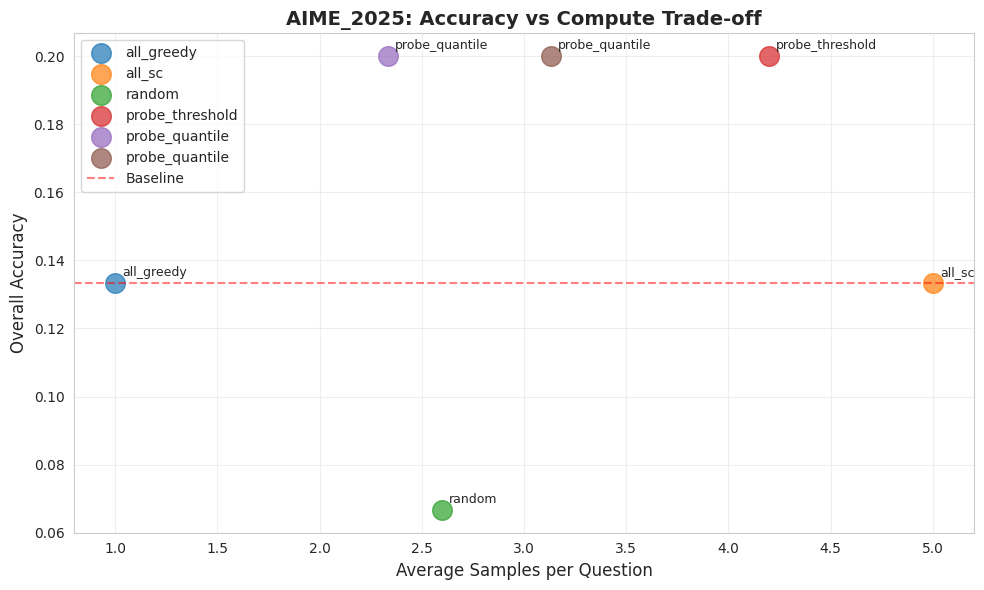

In [15]:
# Plot: Accuracy vs Compute
fig, ax = plt.subplots(figsize=(10, 6))

for m in all_metrics:
    ax.scatter(
        m.avg_samples_per_question,
        m.overall_accuracy,
        s=200,
        alpha=0.7,
        label=m.strategy_name
    )
    ax.annotate(
        m.strategy_name,
        (m.avg_samples_per_question, m.overall_accuracy),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

ax.axhline(BASELINE_ACCURACY, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax.set_xlabel('Average Samples per Question', fontsize=12)
ax.set_ylabel('Overall Accuracy', fontsize=12)
ax.set_title(f'{DATASET_NAME}: Accuracy vs Compute Trade-off', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/accuracy_vs_compute.png', dpi=300, bbox_inches='tight')
plt.show()

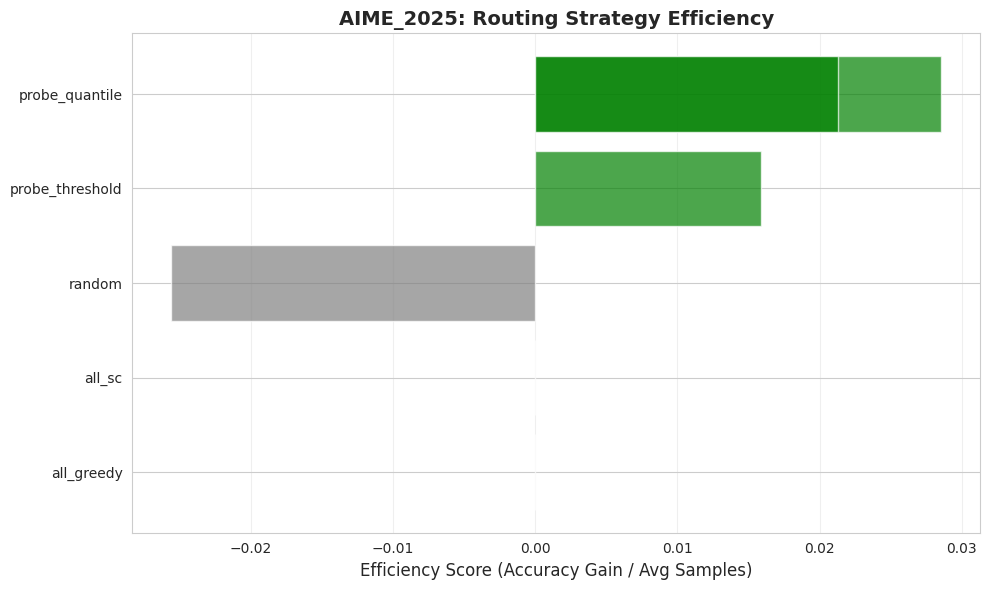

In [16]:
# Plot: Efficiency scores
fig, ax = plt.subplots(figsize=(10, 6))

strategies = [m.strategy_name for m in all_metrics]
efficiencies = [m.efficiency_score() for m in all_metrics]

colors = ['green' if 'probe' in s.lower() else 'gray' for s in strategies]
ax.barh(strategies, efficiencies, color=colors, alpha=0.7)
ax.set_xlabel('Efficiency Score (Accuracy Gain / Avg Samples)', fontsize=12)
ax.set_title(f'{DATASET_NAME}: Routing Strategy Efficiency', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/efficiency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

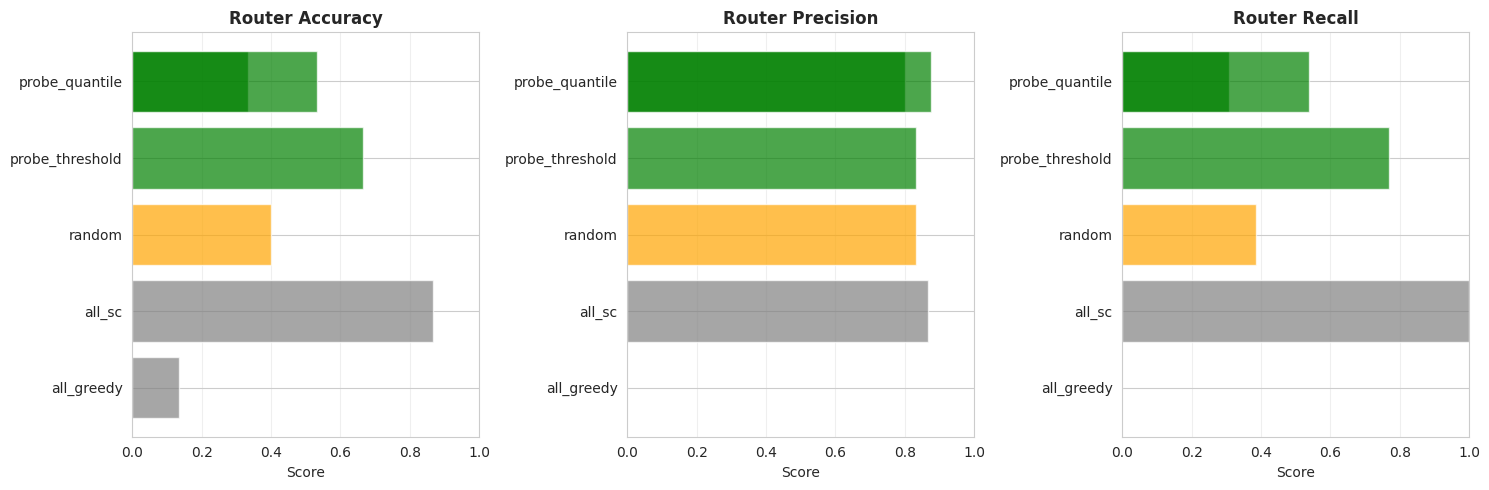

In [17]:
# Plot: Router quality metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = [
    ('router_accuracy', 'Router Accuracy', 0),
    ('router_precision', 'Router Precision', 1),
    ('router_recall', 'Router Recall', 2),
]

for metric_name, title, idx in metrics_to_plot:
    ax = axes[idx]
    strategies = [m.strategy_name for m in all_metrics if getattr(m, metric_name) is not None]
    values = [getattr(m, metric_name) for m in all_metrics if getattr(m, metric_name) is not None]
    
    colors = ['green' if 'probe' in s.lower() else 'orange' if 'random' in s.lower() else 'gray' for s in strategies]
    ax.barh(strategies, values, color=colors, alpha=0.7)
    ax.set_xlabel('Score', fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/router_quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## Deep Dive: Probe-based Routing Analysis

In [18]:
# For best probe-based strategy, analyze which questions benefited
probe_metrics = [m for m in all_metrics if 'probe' in m.strategy_name.lower()]
best_probe_metric = max(probe_metrics, key=lambda m: m.efficiency_score())

print(f"Best probe-based strategy: {best_probe_metric.strategy_name}")
print(best_probe_metric)

Best probe-based strategy: probe_quantile

Strategy: probe_quantile
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: 20.00% (+6.67% vs baseline)
Baseline Accuracy: 13.33%

Routing: 33.3% → SC, 66.7% → Greedy
Avg Samples/Question: 2.33x
Efficiency Score: 0.0286

Router Quality:
  Accuracy: 33.33% (correctly identified hard/easy)
  Precision: 80.00% (SC'd questions that benefited)
  Recall: 30.77% (caught questions that benefit from SC)



In [19]:
# Analyze improvement distribution
best_probe_results = all_results[best_probe_metric.strategy_name]

improvements = []
for idx, result in enumerate(best_probe_results):
    baseline_correct = df.iloc[idx]["baseline_is_correct"]
    improvement = result.is_correct - baseline_correct
    improvements.append(improvement)

df["improvement"] = improvements
df["used_sc"] = [r.used_sc for r in best_probe_results]

print("Improvement distribution:")
print(pd.Series(improvements).value_counts().sort_index())

Improvement distribution:
0    14
1     1
Name: count, dtype: int64


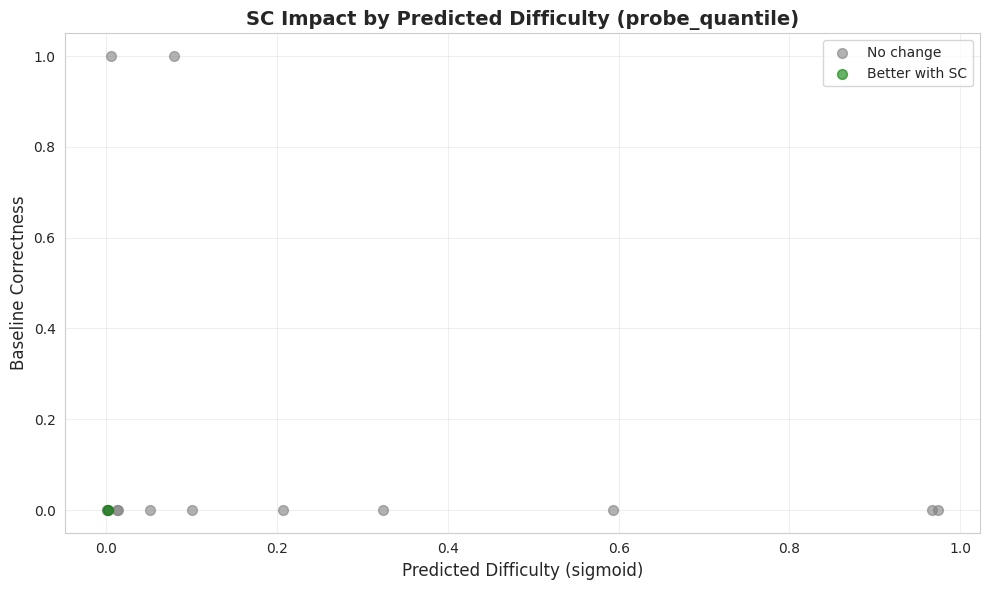

In [20]:
# Plot: improvement by predicted difficulty
fig, ax = plt.subplots(figsize=(10, 6))

colors = {-1: 'red', 0: 'gray', 1: 'green'}
labels = {-1: 'Worse with SC', 0: 'No change', 1: 'Better with SC'}

for improvement_val in [-1, 0, 1]:
    subset = df[df["improvement"] == improvement_val]
    if len(subset) > 0:
        ax.scatter(
            subset["predicted_difficulty_sigmoid"],
            subset["baseline_is_correct"],
            c=colors[improvement_val],
            label=labels[improvement_val],
            alpha=0.6,
            s=50
        )

ax.set_xlabel('Predicted Difficulty (sigmoid)', fontsize=12)
ax.set_ylabel('Baseline Correctness', fontsize=12)
ax.set_title(f'SC Impact by Predicted Difficulty ({best_probe_metric.strategy_name})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/sc_impact_by_difficulty.png', dpi=300, bbox_inches='tight')
plt.show()

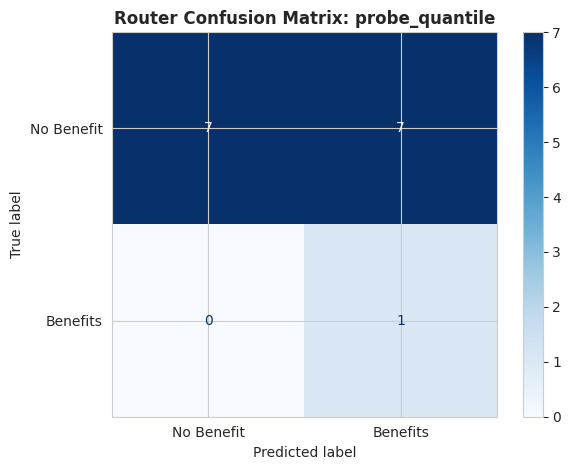

In [21]:
# Confusion matrix for router
# Ground truth: did question benefit from SC? (baseline wrong, SC right)
actually_benefits = (df["baseline_is_correct"] == 0) & (df["improvement"] == 1)
router_sent_to_sc = df["used_sc"]

cm = confusion_matrix(actually_benefits, router_sent_to_sc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Benefit', 'Benefits'])
disp.plot(cmap='Blues')
plt.title(f'Router Confusion Matrix: {best_probe_metric.strategy_name}', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/router_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Results

In [22]:
# Save comparison table
comparison_df.to_csv(f"{RESULTS_DIR}/routing_comparison.csv", index=False)

# Save detailed results for each strategy
for strategy_name, results in all_results.items():
    results_df = pd.DataFrame([
        {
            "question_idx": r.question_idx,
            "used_sc": r.used_sc,
            "is_correct": r.is_correct,
            "num_samples": r.num_samples_used,
            "predicted_score": r.predicted_score,
            "total_tokens": sum(r.token_lengths),
        }
        for r in results
    ])
    
    safe_name = strategy_name.replace("/", "_")
    results_df.to_parquet(f"{RESULTS_DIR}/{MODEL_ALIAS}_{safe_name}_results.parquet")

print(f"\nResults saved to {RESULTS_DIR}/")


Results saved to ../predicting_learnability/MAJORITY_VOTE_DATA/AIME_2025/


## Key Insights

**Questions to answer:**
1. Does probe-based routing beat random routing?
2. What's the efficiency gain of routing vs SC-on-everything?
3. Which questions does the probe miss? (high predicted difficulty but actually easy)
4. Is there a sweet spot for the routing threshold/quantile?

**Next steps:**
- Try different SC sample sizes (k=3, k=10, etc.)
- Test on different datasets (OOD generalization)
- Implement oracle routing (use actual SC benefit as ground truth)
- Try ensemble of probes or more sophisticated routing logic